# Preprocessing Pipeline 3

In [928]:
### imports base

import pandas as pd
import numpy as np
from scipy import stats

### imports analysis

import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

### imports preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler,
                                   FunctionTransformer, PolynomialFeatures, Normalizer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn import set_config
set_config(transform_output='pandas')

### set up system path to access helpers functions

import sys, os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
  sys.path.append(src_path)

# import helpers
from helpers import *


In [929]:
### import class balancers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### import classifier models

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import shap


- try undersampling, force it look for 1 and not just 0
- select k best
- recursive feature elimination on colab or kaggle server, or some other server

In [930]:
# import merged data

df = pd.read_csv('../data/merged_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Feature Engineering

##### DAYS_EMPLOYED_binary

In [931]:
# create a binary feature for DAYS_EMPLOYED, where unemployed, currently suspected to be indicated by 365243, are 1, else 0

df['DAYS_EMPLOYED_no_job'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,DAYS_EMPLOYED_no_job
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


OCCUPATION_TYPE_none

In [932]:
# create a binary feature for OCCUPATION_TYPE, where nulls are 0, everything else is 1

df['OCCUPATION_TYPE_none'] = (df['OCCUPATION_TYPE'].isna()).astype(int)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,DAYS_EMPLOYED_no_job,OCCUPATION_TYPE_none
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


# Feature Cleaning

In [933]:
# replace DAYS_EMPLOYED's placeholder value of 365243 with 365

df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 365)

# Drop Outliers

In [934]:
# define the outlier remover custom transformer imported from src.helpers

outlier_remover = OutlierRemover(columns=[], iqr_multiplier=5)

# list the features to remove outliers from

outlier_cols = []

# create the preprocessor

preprocessor_outliers = ColumnTransformer([
  ('outlier_remover', outlier_remover, outlier_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Feature Filter

In [935]:
# create a list of the feature to keep

cols_original_keep = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
             'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_EMPLOYED_no_job',
             'DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL',
             'OCCUPATION_TYPE','OCCUPATION_TYPE_none','CNT_FAM_MEMBERS','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START',
             'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

cols_engineered_keep = ['num_bureau_records','num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                        'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                        'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                        'prev_avg_ratio_credit_approved',
                        'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                        'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA',
                        'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                        'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                        'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                        'prev_contract_type_revolving','prev_contract_type_XNA',
                        'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed',
                        ]

cols_keep = cols_original_keep + cols_engineered_keep

cols_drop = ['OWN_CAR_AGE','FLAG_MOBIL','FLAG_CONT_MOBILE','REGION_RATING_CLIENT_W_CITY','ORGANIZATION_TYPE',
             'most_recent_bureau_apply','max_days_bureau_overdue',
             'avg_bureau_credit_enddate','max_bureau_overdue_amt','ttl_cnt_bureau_prolong',
             'bureau_type_Auto','bureau_type_Business','bureau_type_Consumer','bureau_type_Real Estate',
             'bureau_type_Other','ttl_bureau_active_annuity','avg_bb_status_sum','avg_bb_status_mean',
             'cc_status_active_ttl','cc_status_completed_ttl','cc_status_negative_ttl','pos_avg_DPD_DEF',
             'pos_status_demand','prev_binary_rejected',
              'PRODUCT_COMBINATION_Card Street','PRODUCT_COMBINATION_Card X-Sell','PRODUCT_COMBINATION_Cash',
              'PRODUCT_COMBINATION_Cash Street: high','PRODUCT_COMBINATION_Cash Street: low',
              'PRODUCT_COMBINATION_Cash Street: middle','PRODUCT_COMBINATION_Cash X-Sell: high',
              'PRODUCT_COMBINATION_Cash X-Sell: low','PRODUCT_COMBINATION_Cash X-Sell: middle',
              'PRODUCT_COMBINATION_POS household with interest','PRODUCT_COMBINATION_POS household without interest',
              'PRODUCT_COMBINATION_POS industry with interest','PRODUCT_COMBINATION_POS industry without interest',
              'PRODUCT_COMBINATION_POS mobile with interest','PRODUCT_COMBINATION_POS mobile without interest',
              'PRODUCT_COMBINATION_POS other with interest',]

In [936]:
# create a column transformer to filter unwanted columns

preprocessor_filter = ColumnTransformer([
  ('passthrough', 'passthrough', cols_keep)
], remainder='drop', verbose_feature_names_out=False)

# Imputing

In [937]:
# list the imputing features

impute_freq_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                    'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY']
impute_zero_cols = ['CNT_CHILDREN','DAYS_EMPLOYED_no_job','OCCUPATION_TYPE_none','num_bureau_records',
                    'num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                    'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                    'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                    'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                    'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA']
impute_none_cols = ['OCCUPATION_TYPE']
impute_median_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','HOUR_APPR_PROCESS_START',
                      'CNT_FAM_MEMBERS','prev_avg_ratio_credit_approved',
                      'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                      'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                      'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                      'prev_contract_type_revolving','prev_contract_type_XNA',
                      'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed',
                      ]
impute_one_cols = []


# assemble the preprocess

preprocessor_imputing = ColumnTransformer([
  ('impute_most_frequent', SimpleImputer(strategy='most_frequent'), impute_freq_cols),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), impute_zero_cols),
  ('impute_one', SimpleImputer(strategy='constant', fill_value=1), impute_one_cols),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), impute_none_cols),
  ('impute_median', SimpleImputer(strategy='median'), impute_median_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Encoding

In [938]:
# define the encoders

ohe = OneHotEncoder(drop='if_binary', min_frequency=100, sparse_output=False)

# list the encoding features

ohe_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_encoding = ColumnTransformer([
  ('ohe', ohe, ohe_cols),
], remainder='passthrough', verbose_feature_names_out=False)

# Log Transform

In [939]:
# list the log features

log_transform_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS']

# create a function transformer to do log transformation

def log_transform_df(X):
  return np.log1p(X)

log_transformer = FunctionTransformer(log_transform_df)


# define the preprocessor

preprocessor_log = ColumnTransformer([
  ('log_transformer', log_transformer, log_transform_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Scaling

In [940]:
# list the scaling features

standard_scaler_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_BIRTH',
                        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                        'HOUR_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_scaling = ColumnTransformer([
  ('StandardScaler', StandardScaler(), standard_scaler_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Train-test-split

In [941]:
# train-test-split

X = df.drop(columns=['SK_ID_CURR','TARGET'])
y = df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

In [942]:
# define the main pipe

main_pipe = Pipeline([('preprocessor_filter', preprocessor_filter),
                      ('preprocessor_outliers',preprocessor_outliers),
                      ('preprocessor_imputing', preprocessor_imputing),
                      ('preprocessor_encoding', preprocessor_encoding),
                      ('preprocessor_log', preprocessor_log),
                      ('preprocessor_scaling', preprocessor_scaling)
                      ])

In [943]:
# check the pipe

main_pipe

Pipeline(steps=[('preprocessor_filter',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'R...
                ('preprocessor_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START'])],
                                   verbose_feature_names_out=False))])

# Modeling

### 1. Logistic Regression - Undersampling

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.62      0.75    226148
           1       0.13      0.66      0.22     19860

    accuracy                           0.63    246008
   macro avg       0.54      0.64      0.49    246008
weighted avg       0.89      0.63      0.71    246008



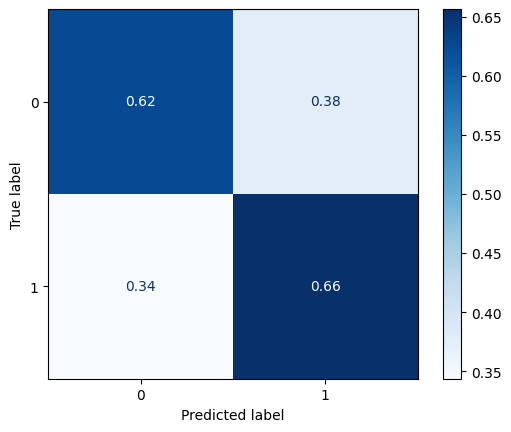

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56538
           1       0.13      0.65      0.22      4965

    accuracy                           0.63     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.63      0.71     61503



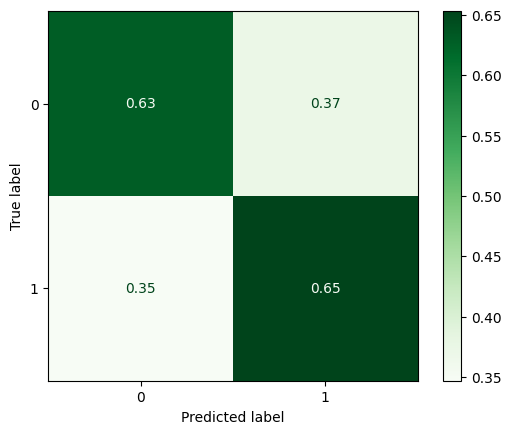

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.627093,0.63101,0.133073,0.133925,0.656294,0.653172,0.221279,0.222276,0.690349,0.692205


In [944]:
# define pipeline for LR
estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, RandomUnderSampler(), LogisticRegression(max_iter=1000))

# check the results

model_results = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR undersampling', pos_label=1)
model_results

### 2. Logistic Regression - Weighted

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76    226148
           1       0.13      0.66      0.22     19860

    accuracy                           0.63    246008
   macro avg       0.54      0.64      0.49    246008
weighted avg       0.89      0.63      0.71    246008



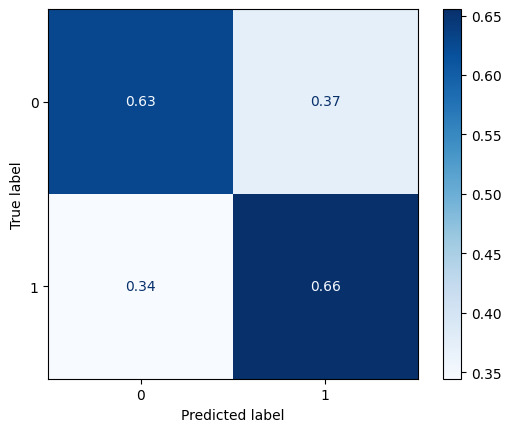

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56538
           1       0.13      0.65      0.22      4965

    accuracy                           0.63     61503
   macro avg       0.54      0.64      0.49     61503
weighted avg       0.89      0.63      0.72     61503



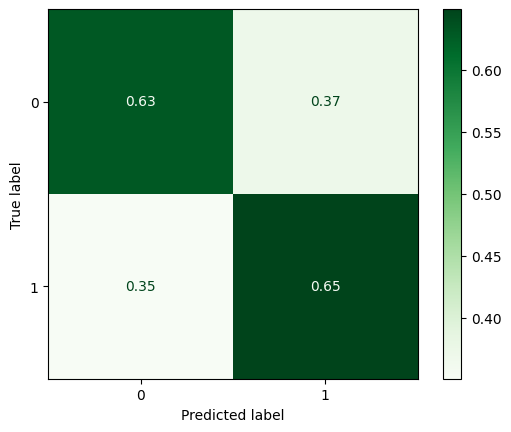

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.627093,0.631010,0.133073,0.133925,0.656294,0.653172,0.221279,0.222276,0.690349,0.692205
LR balanced,0.628878,0.631953,0.133552,0.133640,0.655488,0.649144,0.221895,0.221649,0.690673,0.692756


In [945]:
# define pipeline for LR with weighted classes

estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced'))

# check the results

model_results = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 3. DecisionTree

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.75    226148
           1       0.13      0.67      0.22     19860

    accuracy                           0.62    246008
   macro avg       0.54      0.64      0.48    246008
weighted avg       0.89      0.62      0.70    246008



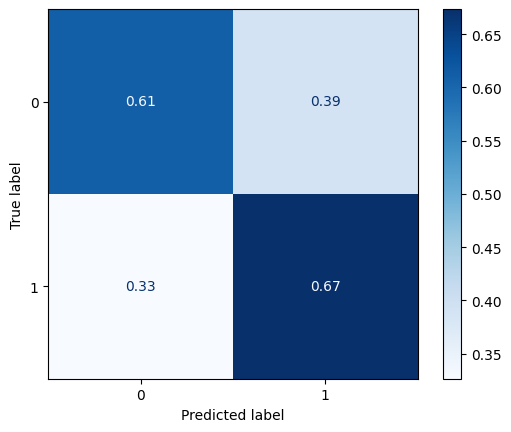

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     56538
           1       0.12      0.63      0.21      4965

    accuracy                           0.61     61503
   macro avg       0.54      0.62      0.47     61503
weighted avg       0.88      0.61      0.70     61503



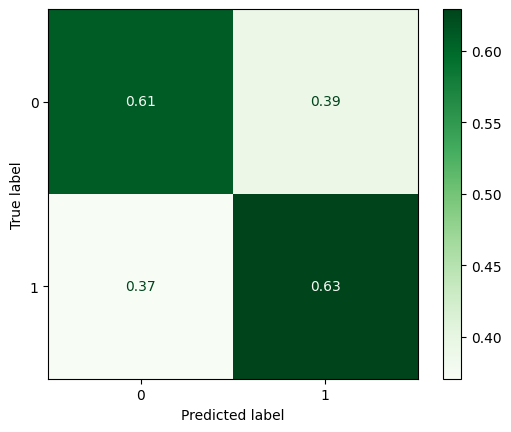

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.627093,0.631010,0.133073,0.133925,0.656294,0.653172,0.221279,0.222276,0.690349,0.692205
LR balanced,0.628878,0.631953,0.133552,0.133640,0.655488,0.649144,0.221895,0.221649,0.690673,0.692756
DecisionTree leaf=100 d=10,0.615984,0.611336,0.131969,0.124032,0.673565,0.629204,0.220697,0.207217,0.692297,0.663661


In [946]:
# define DecisionTree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
dt_pipe = make_pipeline(*estimators, RandomUnderSampler(), dt)

model_results = eval_classification(dt_pipe, X_train, y_train, X_test, y_test, model_name='DecisionTree leaf=100 d=10',
                                    results_frame=model_results)
model_results

### 4. XBGClassifier

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.80    226148
           1       0.16      0.70      0.26     19860

    accuracy                           0.68    246008
   macro avg       0.56      0.69      0.53    246008
weighted avg       0.90      0.68      0.76    246008



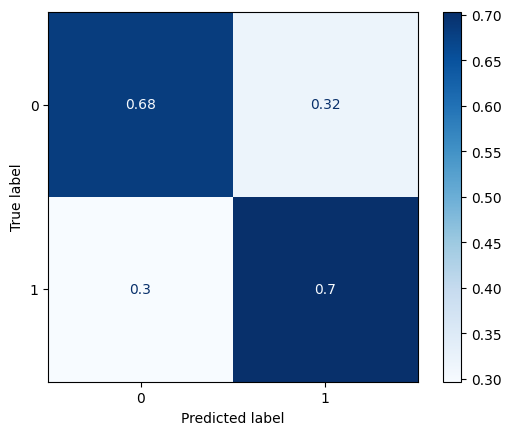

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56538
           1       0.15      0.66      0.25      4965

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



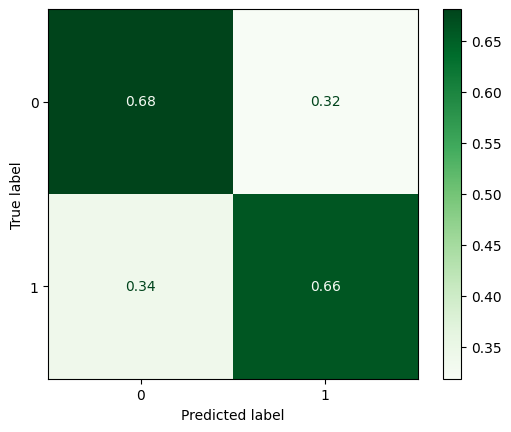

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.627093,0.631010,0.133073,0.133925,0.656294,0.653172,0.221279,0.222276,0.690349,0.692205
LR balanced,0.628878,0.631953,0.133552,0.133640,0.655488,0.649144,0.221895,0.221649,0.690673,0.692756
DecisionTree leaf=100 d=10,0.615984,0.611336,0.131969,0.124032,0.673565,0.629204,0.220697,0.207217,0.692297,0.663661
XGB balanced,0.683307,0.679674,0.162392,0.154052,0.702971,0.660826,0.263836,0.249857,0.759077,0.730098


In [947]:
# define XGBClassifier

xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
xgb_pipe = make_pipeline(*estimators, RandomUnderSampler(), xgb)

model_results = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, model_name='XGB balanced',
                                    results_frame=model_results)
model_results

# Check Feature Importances

In [948]:
# check permutation importances

estimators = [step[1] for step in main_pipe.steps]

# lr_model = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced')).fit(X_train, y_train)
xgb_model = make_pipeline(*estimators, xgb).fit(X_train, y_train)

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:19:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [949]:
# use SHAP to evaluate feature importances

X_train_proc = main_pipe.transform(X_train.sample(1000))

# explainer = shap.LinearExplainer(lr_model[-1], X_train_proc)
explainer = shap.Explainer(xgb_model[-1], X_train_proc)
shap_values = explainer(X_train_proc)

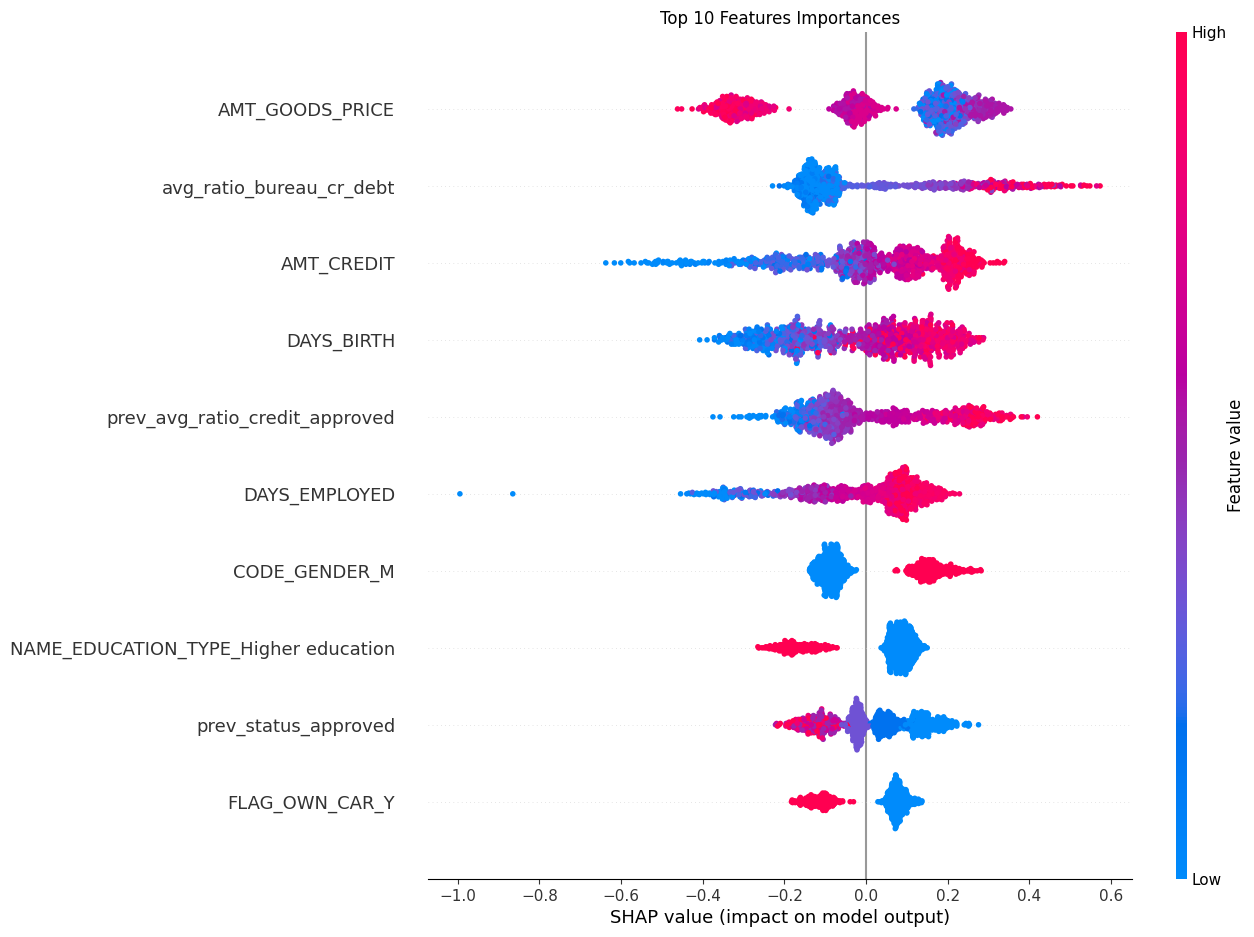

In [950]:
# plot the SHAP summary plot to see the impact of top 50 features

shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, show=False, max_display=10)
plt.gcf().set_size_inches(20,10)
plt.gcf().savefig('shap_plot_10.png', dpi=300)
plt.title('Top 10 Features Importances')
plt.show()

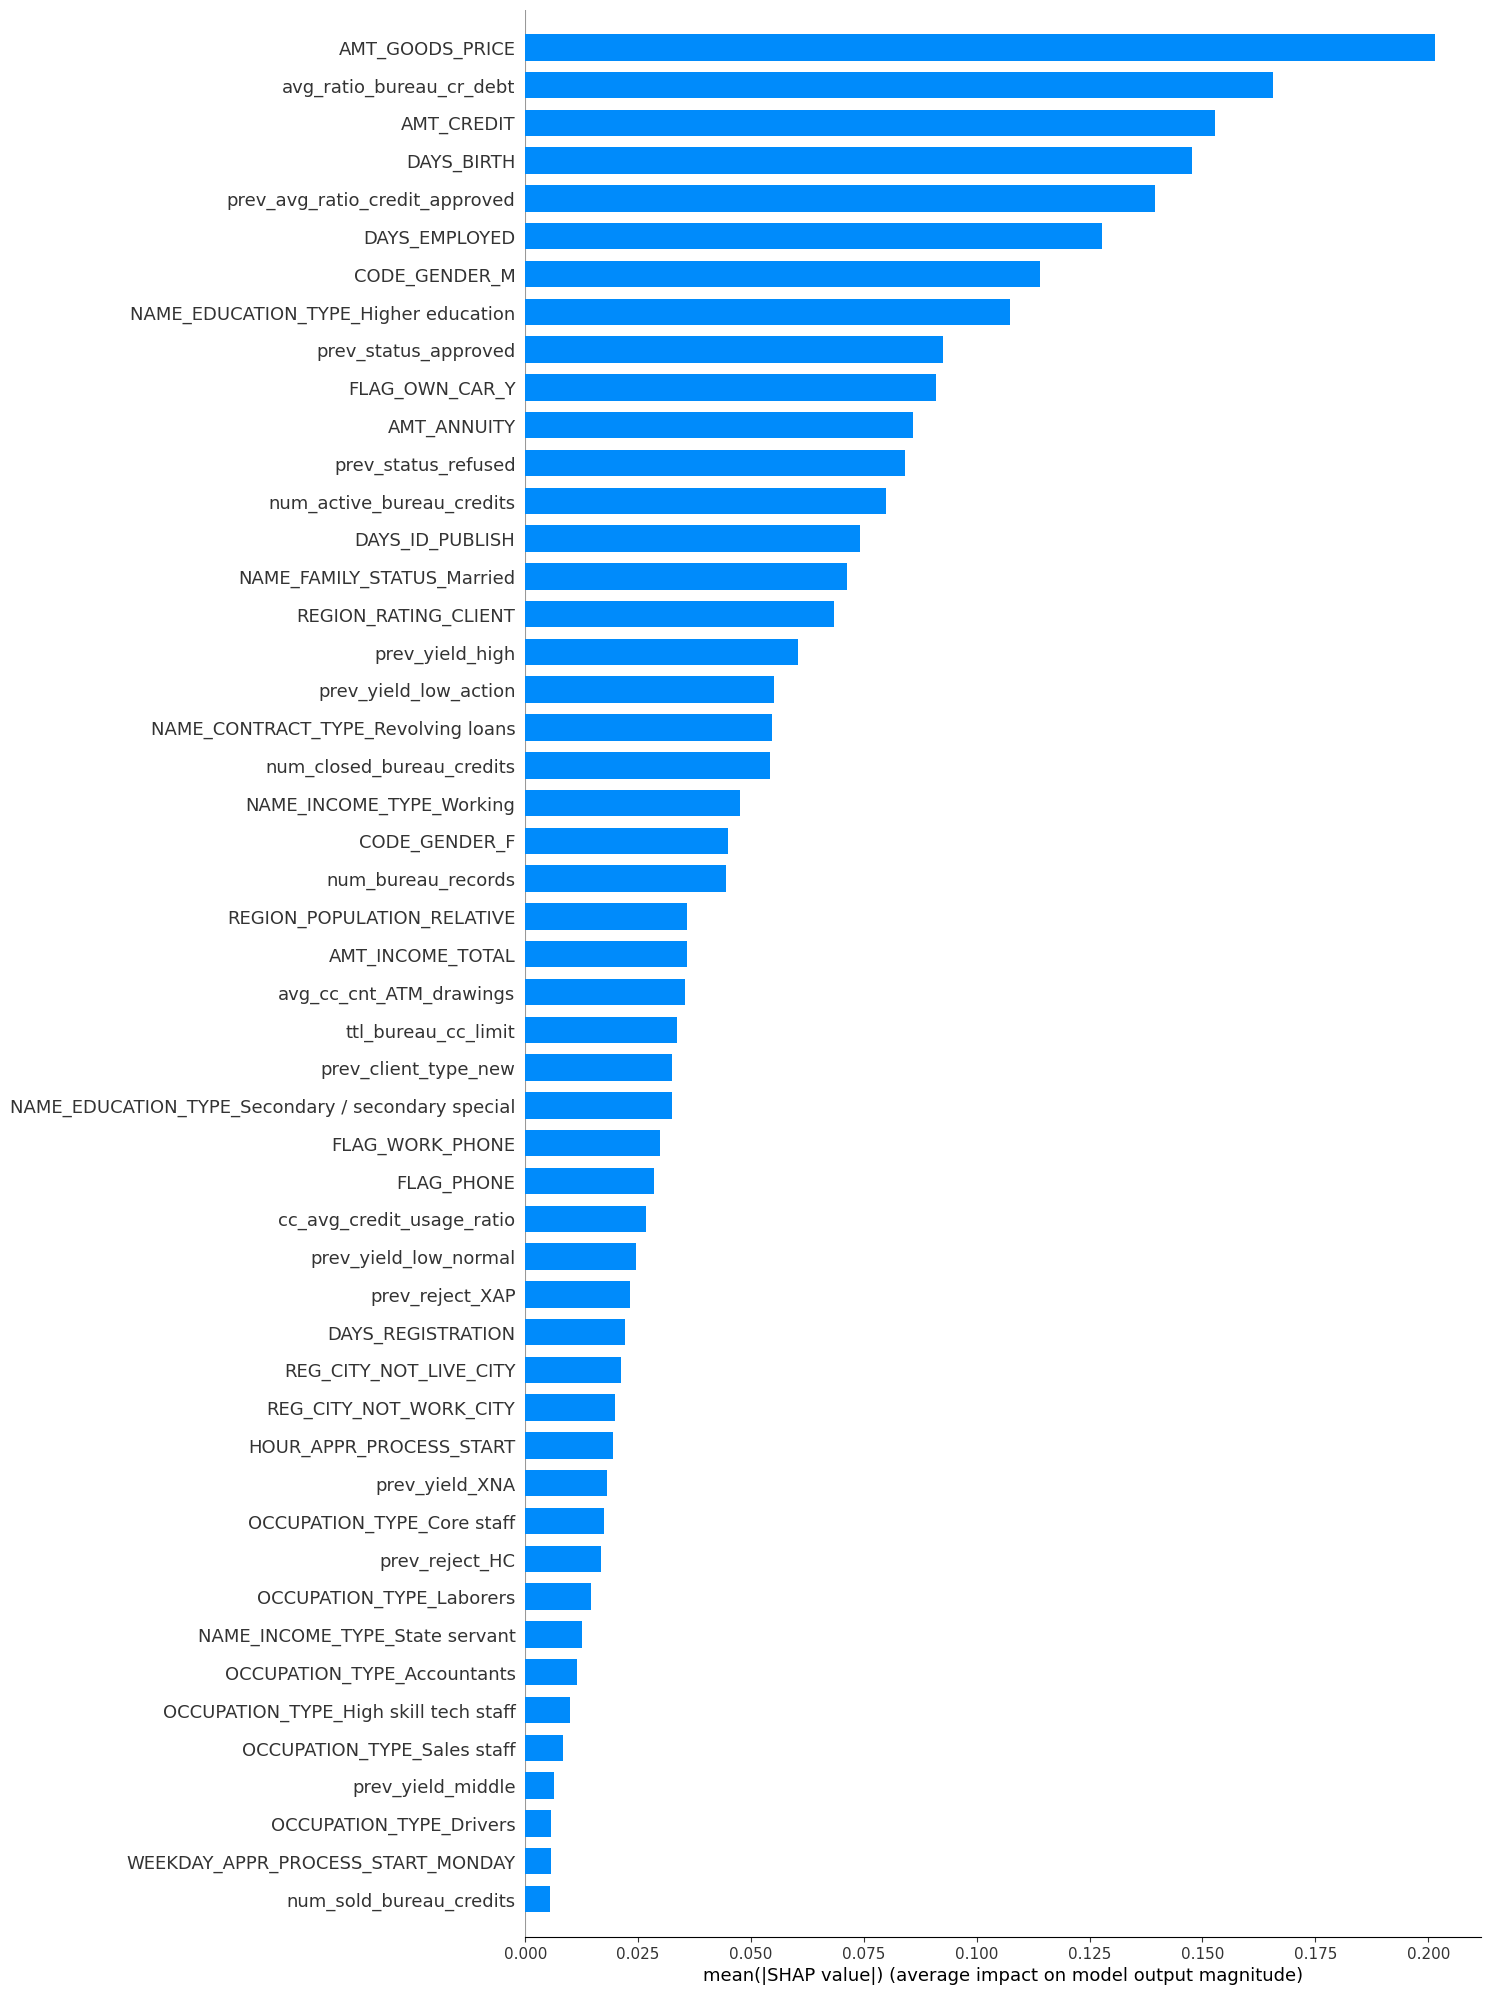

In [951]:
shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, plot_type='bar', max_display=50, show=False)
plt.gcf().set_size_inches(30,20)
plt.show()

In [952]:
# Create a DataFrame with feature importance

feature_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train_proc.columns,
    'importance': feature_importance
})

# get the 20 lowest importances
feature_importance_df.sort_values(by='importance', ascending=True).head(40)

,feature,importance
73,DAYS_EMPLOYED_no_job,0.000000
78,num_bad_bureau_credits,0.000000
29,NAME_INCOME_TYPE_infrequent_sklearn,0.000000
93,prev_reject_SYSTEM,0.000000
26,NAME_INCOME_TYPE_Pensioner,0.000000
40,NAME_FAMILY_STATUS_infrequent_sklearn,0.000000
21,NAME_TYPE_SUITE_Other_A,0.000000
20,NAME_TYPE_SUITE_Group of people,0.000000
58,OCCUPATION_TYPE_Medicine staff,0.000000
15,CODE_GENDER_infrequent_sklearn,0.000000
